In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, Dense

In [27]:
(train_data, test_data), ds_info = tfds.load("food101",
                                             data_dir="D:\Food Vision",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             with_info=True,
                                             as_supervised=True)

In [3]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-54c2f5e1-6865-3a7b-93c9-3a6e051ac3f0)


In [10]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
def resize_images(image, label):
    image = tf.image.resize(image, size=(224,224)) # resize
    image = tf.cast(image, dtype=tf.float32)    # change data type
    return image, label

In [28]:
train_data = train_data.map(map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
# batch size is small cause images are big and I want to avoid a GPU overload
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#test_data doesn't need to be shuffled
test_data = test_data.map(map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

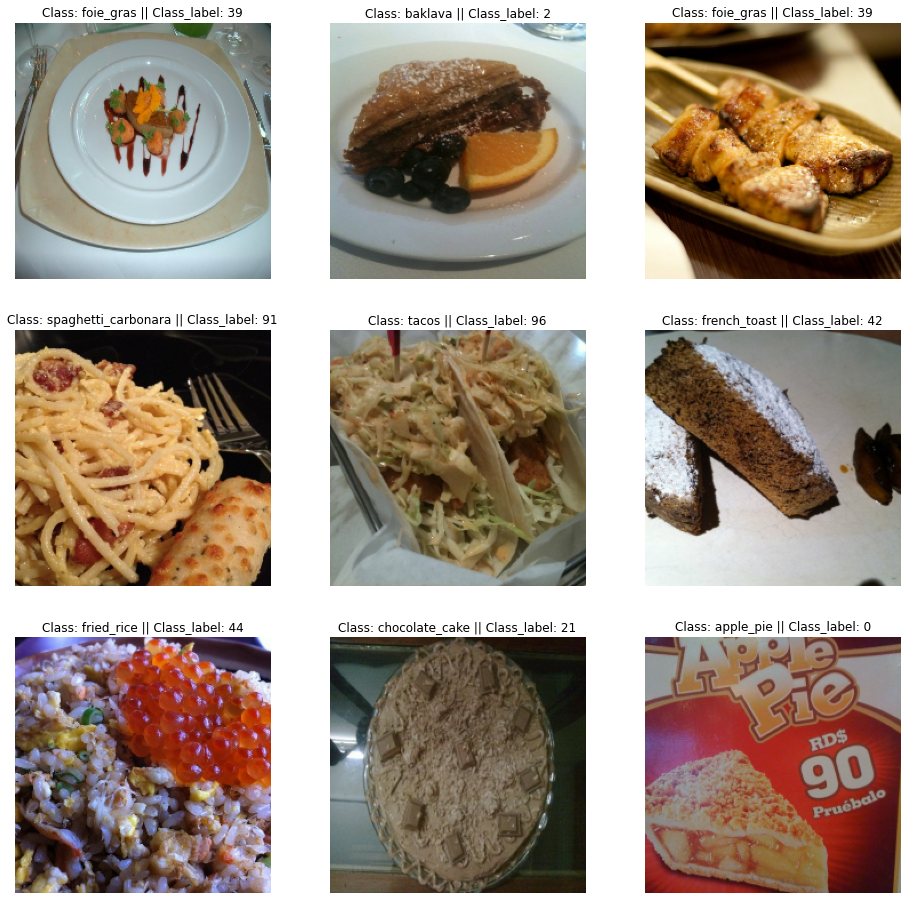

In [22]:
# Plot 9 random images
plt.figure(figsize=(16,16))
for i in range(9):
    for image,label in train_data.take(1):
        image = image/255.
        plt.subplot(3,3,i+1)
        plt.imshow(image[0])
        plt.title("Class: " + class_names[label[0].numpy()] + " || Class_label: " + str(label[0].numpy()))
        plt.axis(False);

In [29]:
# To check data properties
train_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

In [32]:
# mixed_precision allow gpu to use both float16 and float32 datatype
# in order to run faster the model and use less memory
mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

<Policy "mixed_float16">

In [33]:
# Calllback to produce graphs and visualizations of model's metrics 
# on the Tensorboard Dev site.
def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

# Callback to create a checkpoint of the model
def model_checkpoint(directory, name):
    log_dir = directory + "/" + name
    m_c = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir,
                                             monitor="val_accuracy",
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
    return m_c

In [34]:
# Load pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False) # To use our own output
base_model.trainable = False # To do only feature extraction and not fine-tuning

16719872/16705208 [==============================] - 0s 0us/step


In [37]:
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = base_model(inputs, training = False) # We not fine tune the model yet
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Dense(101, name='outputLayer')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")
model.summary()

Model: "FeatureExtractionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 poolingLayer (GlobalAverage  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 outputLayer (Dense)         (None, 101)               129381    
                                                                 
 activationLayer (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 12

In [38]:
# Infos about each layer
for lnum, layer in enumerate(model.layers):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 inputLayer True float32 <Policy "float32">
1 efficientnetb0 False float32 <Policy "mixed_float16">
2 poolingLayer True float32 <Policy "mixed_float16">
3 outputLayer True float32 <Policy "mixed_float16">
4 activationLayer True float32 <Policy "float32">


In [39]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

hist_model = model.fit(train_data,
                       epochs = 3,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(0.1 * len(test_data)),
                       callbacks=[tensorboard_callback("Tensorboard","model"),
                                  model_checkpoint("Checkpoints","model.ckpt")])

/home/borriero/.local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3


2022-02-11 09:57:28.926466: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-02-11 09:57:29.568213: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2368/2368 [==============================] - ETA: 0s - loss: 1.8178 - accuracy: 0.5586
Epoch 00001: val_accuracy improved from -inf to 0.67247, saving model to Checkpoints/model.ckpt
2368/2368 [==============================] - 42s 15ms/step - loss: 1.8178 - accuracy: 0.5586 - val_loss: 1.2509 - val_accuracy: 0.6725
Epoch 2/3
2364/2368 [============================>.] - ETA: 0s - loss: 1.2937 - accuracy: 0.6662
Epoch 00002: val_accuracy improved from 0.67247 to 0.69422, saving model to Checkpoints/model.ckpt
2368/2368 [==============================] - 35s 15ms/step - loss: 1.2941 - accuracy: 0.6661 - val_loss: 1.1303 - val_accuracy: 0.6942
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1453 - accuracy: 0.7016
Epoch 00003: val_accuracy improved from 0.69422 to 0.70649, saving model to Checkpoints/model.ckpt
2368/2368 [==============================] - 35s 15ms/step - loss: 1.1453 - accuracy: 0.7016 - val_loss: 1.0865 - val_accuracy: 0.7065


In [40]:
model_results = model.evaluate(test_data)

790/790 [==============================] - 9s 12ms/step - loss: 1.0909 - accuracy: 0.7073


In [41]:
# Let's allow fine tuning
base_model.trainable = True

In [42]:
# I don't want batch normalization layer to be trainable
for layer in model.layers[1].layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

In [43]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              # I have to reduce learning rate during fine tuning
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])
hist_model_tuned = model.fit(train_data,
                             epochs=5,
                             steps_per_epoch=len(train_data),
                             validation_data=test_data,
                             validation_steps=int(0.1*len(test_data)),
                             # Start from the final epoch of the feature extraction step
                             initial_epoch=hist_model.epoch[-1],
                             callbacks=[tensorboard_callback("Tensorboard", "model_tuned"),
                                        model_checkpoint("Checkpoints", "model_tuned.ckpt")])

Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 0.9217 - accuracy: 0.7509
Epoch 00003: val_accuracy improved from -inf to 0.76068, saving model to Checkpoints/model_tuned.ckpt
2368/2368 [==============================] - 100s 39ms/step - loss: 0.9217 - accuracy: 0.7509 - val_loss: 0.8603 - val_accuracy: 0.7607
Epoch 4/5
2368/2368 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.8454
Epoch 00004: val_accuracy improved from 0.76068 to 0.77294, saving model to Checkpoints/model_tuned.ckpt
2368/2368 [==============================] - 93s 39ms/step - loss: 0.5652 - accuracy: 0.8454 - val_loss: 0.8477 - val_accuracy: 0.7729
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.9136
Epoch 00005: val_accuracy did not improve from 0.77294
2368/2368 [==============================] - 92s 39ms/step - loss: 0.3070 - accuracy: 0.9136 - val_loss: 0.9291 - val_accuracy: 0.7674


In [44]:
model_tuned_results = model.evaluate(test_data)

790/790 [==============================] - 9s 12ms/step - loss: 0.9714 - accuracy: 0.7641


In [ ]:
!tensorboard dev upload --logdir ./Tensorboard \
 --name "Food101"\
 --description "Feature Extraction Model vs Fine Tuned Model"\
 --one_shot

In [47]:
def compare_histories(original_history, new_history, initial_epochs):
    """
    Compares two model history objects.
    """
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(9, 9))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

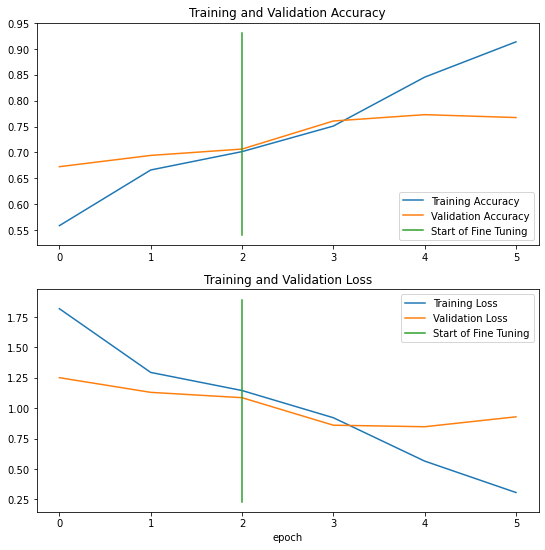

In [48]:
compare_histories(hist_model, hist_model_tuned, initial_epochs=3)

In [49]:
preds = model.predict(test_data, verbose = 1)
pred_labels = tf.argmax(preds, axis=1)
test_labels = np.concatenate([y for x, y in test_data], axis=0)

790/790 [==============================] - 9s 10ms/step
